In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

db = "chinook.db"

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(q):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(q)
        
def show_tables():
    q = '''
        SELECT 
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table", "view")'''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
albums_sold = '''
    WITH track_sold_USA AS 
    (SELECT il.* from invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id   
     INNER JOIN customer c ON c.customer_id = i.customer_id
     WHERE c.country = "USA")
     
     SELECT
         g.name genre_name,
         COUNT(tsu.invoice_line_id) track_sold,
         ((CAST(COUNT(tsu.invoice_line_id) as FLOAT)) / 
             (SELECT COUNT(*) from track_sold_USA)) percent_track_sold
     FROM track_sold_USA tsu
     INNER JOIN track t ON t.track_id = tsu.track_id
     INNER JOIN genre g ON g.genre_id = t.genre_id
     GROUP BY 1
     ORDER BY 2 DESC
     LIMIT 15
     '''
run_query(albums_sold)

,genre_name,track_sold,percent_track_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


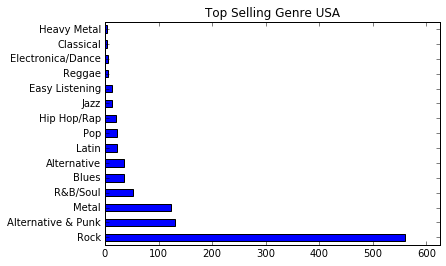

In [3]:
genre_sales_usa = run_query(albums_sold)
genre_sales_usa.set_index("genre_name", drop=True, inplace=True)

genre_sales_usa['track_sold'].plot.barh(title = "Top Selling Genre USA", xlim=(0, 625))

plt.ylabel("")
plt.show()

In [4]:
agent_sale_query = '''
    WITH track_sold AS 
    (SELECT 
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total_purchase
     FROM invoice i
     INNER JOIN customer c ON c.customer_id = i.customer_id
     GROUP BY 1, 2)
     
     SELECT 
         e.first_name || " " || e.last_name agent_name,
         e.birthdate,
         e.hire_date,
         SUM(ts.total_purchase) total_purchase
     FROM track_sold ts
     INNER JOIN employee e ON e.employee_id = ts.support_rep_id
     GROUP BY 1
     ORDER BY 4 DESC
    '''

run_query(agent_sale_query)

,agent_name,birthdate,hire_date,total_purchase
0,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,1731.51
1,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,1584.00
2,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,1393.92


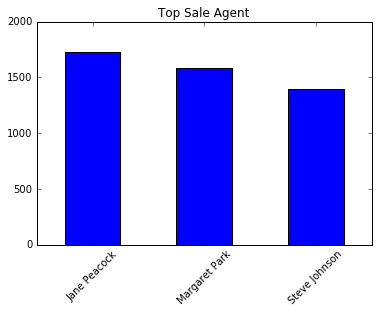

In [5]:
agent_sale = run_query(agent_sale_query)
agent_sale.set_index("agent_name", drop=True, inplace=True)

agent_sale["total_purchase"].plot.bar(title = "Top Sale Agent", ylim = (0, 2000))

plt.ylabel("")
plt.xlabel("")
plt.xticks(rotation=45)

plt.show()

In [6]:
country_purchase = '''
WITH country_or_other AS
    (SELECT
        CASE
            WHEN
                (SELECT count(*) FROM customer
                 WHERE country = c.country) = 1 THEN "OTHER"
             ELSE c.country
         END AS country,
         c.customer_id,
         il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
     SELECT 
         country,
         total_customer,
         total_sale,
         avg_sale_per_customer,
         avg_order_value
     FROM 
         (
         SELECT
             country,
             COUNT(distinct customer_id) total_customer,
             SUM(unit_price) total_sale,
             (CAST(SUM(unit_price) as FLOAT) / COUNT(distinct customer_id)) avg_sale_per_customer,
             (CAST(SUM(unit_price) as FLOAT) / COUNT(distinct invoice_id)) avg_order_value,
             CASE
                 WHEN  country = "OTHER" THEN 1
                 ELSE 0
             END AS sort
         FROM country_or_other
         GROUP BY country
         ORDER BY sort ASC, total_sale DESC
         )
'''

run_query(country_purchase)

,country,total_customer,total_sale,avg_sale_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,OTHER,15,1094.94,72.996000,7.448571


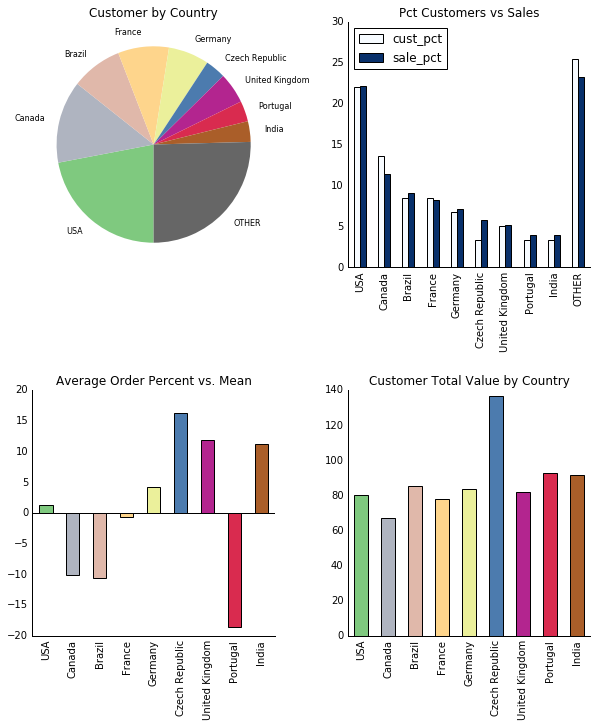

In [7]:
from matplotlib import cm
import numpy as np

country_stat = run_query(country_purchase)
country_stat.set_index("country", drop=True, inplace=True)

fig = plt.figure(figsize = (10,11))
fig.subplots_adjust(hspace=.5, wspace=.3)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

my_colors = cm.Accent(np.linspace(0,1,country_stat.shape[0]))

# Top Left
total_customer_pie = country_stat["total_customer"].copy().rename("")
total_customer_pie.plot.pie(
    ax=ax1, 
    title = "Customer by Country",
    labeldistance = 1.15, 
    startangle=-90,
    wedgeprops = {'linewidth': 0},
    colormap=plt.cm.Accent,
    fontsize = 8, counterclock = False)

# Top Right
col = ["total_customer", "total_sale"]
sale_cust_pct = country_stat[col].copy()

sale_cust_pct["sale_pct"] = sale_cust_pct["total_sale"] / sale_cust_pct["total_sale"].sum() * 100
sale_cust_pct["cust_pct"] = sale_cust_pct["total_customer"] / sale_cust_pct["total_customer"].sum() * 100
chart_col = ["cust_pct", "sale_pct"]
sale_cust_pct.index.name = ""

sale_cust_pct[chart_col].plot.bar(
    ax=ax2, colormap = plt.cm.Blues, title="Pct Customers vs Sales")

ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Bottom Left
avg_order = country_stat["avg_order_value"].copy()
avg_order_diff = (avg_order - avg_order.mean())/ avg_order.mean() * 100
avg_order_diff = avg_order_diff[0:len(avg_order_diff)-1]
avg_order_diff.index.name = ""

avg_order_diff.plot.bar(
    ax=ax3, title = "Average Order Percent vs. Mean",
    color = my_colors)

ax3.axhline(y = 0, color ="k")
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)


# Bottom Right

customer_tot_val = country_stat["avg_sale_per_customer"].copy()
customer_tot_val = customer_tot_val[0:len(customer_tot_val)-1]
customer_tot_val.index.name = ""

customer_tot_val.plot.bar(
    ax = ax4,
    title = "Customer Total Value by Country",
    color = my_colors)

ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

In [10]:
album_vs_track = '''
WITH get_first_tract AS (
    SELECT 
        invoice_id,
        MIN(track_id) first_track_id
    FROM invoice_line
    GROUP BY 1)
    
SELECT
    album_purchase,
    COUNT(invoice_id) total_invoice,
    (CAST(COUNT(invoice_id) as FLOAT) / (SELECT COUNT(*) FROM invoice) * 100) percent
FROM (
    SELECT
        gft.*,
        CASE
            WHEN
                (SELECT t.track_id FROM track t
                WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = gft.first_track_id)
                EXCEPT
                
                SELECT il.track_id FROM invoice_line il
                WHERE il.invoice_id = gft.invoice_id
                ) IS NULL
                
                AND
                
                (SELECT il.track_id FROM invoice_line il
                WHERE il.invoice_id = gft.invoice_id
                
                EXCEPT
                
                SELECT t.track_id FROM track t
                WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = gft.first_track_id)
                ) IS NULL
            THEN "yes"
            ELSE "no"
        END AS album_purchase
        FROM get_first_tract gft
        )
GROUP BY album_purchase

'''

run_query(album_vs_track)

,album_purchase,total_invoice,percent
0,no,500,81.433225
1,yes,114,18.566775
